In [1]:
from google.colab import files
files.upload()  # Upload your kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sanyabatraaa","key":"f8e281ca58dd92f58e038a7be740ad3f"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:42<00:00, 49.8MB/s]
100% 2.29G/2.29G [00:42<00:00, 57.4MB/s]


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.optimizers import Adam

IMG_SIZE = 224
BATCH_SIZE = 16

train_path = "chest_xray/train"
val_path = "chest_xray/val"
test_path = "chest_xray/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(train_path, target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary', batch_size=BATCH_SIZE)
val_gen = val_datagen.flow_from_directory(val_path, target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary', batch_size=BATCH_SIZE)
test_gen = test_datagen.flow_from_directory(test_path, target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary', batch_size=1, shuffle=False)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=preds)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 6,954,881 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [5]:
history = model.fit(train_gen, validation_data=val_gen, epochs=5)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 231s 233ms/step - accuracy: 0.9101 - loss: 0.2055 - val_accuracy: 0.5000 - val_loss: 1.5678
Epoch 2/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 64s 197ms/step - accuracy: 0.9777 - loss: 0.0654 - val_accuracy: 1.0000 - val_loss: 0.0657
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 65s 197ms/step - accuracy: 0.9909 - loss: 0.0269 - val_accuracy: 0.9375 - val_loss: 0.0576
Epoch 4/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 65s 198ms/step - accuracy: 0.9943 - loss: 0.0156 - val_accuracy: 0.9375 - val_loss: 0.0852
Epoch 5/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 65s 199ms/step - accuracy: 0.9954 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 0.0590


In [6]:
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc * 100:.2f}%")


624/624 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.5924 - loss: 2.2575
Test Accuracy: 76.44%


In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get true labels and predictions
y_true = test_gen.classes
y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Classification report
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))


624/624 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step
              precision    recall  f1-score   support

      NORMAL       1.00      0.37      0.54       234
   PNEUMONIA       0.73      1.00      0.84       390

    accuracy                           0.76       624
   macro avg       0.86      0.69      0.69       624
weighted avg       0.83      0.76      0.73       624



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.7450 - loss: 0.4900

163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 625ms/step - accuracy: 0.7456 - loss: 0.4892 - val_accuracy: 0.8750 - val_loss: 0.3724 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9116 - loss: 0.2080

163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 588ms/step - accuracy: 0.9116 - loss: 0.2080 - val_accuracy: 0.8125 - val_loss: 0.2761 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 591ms/step - accuracy: 0.9216 - loss: 0.1839 - val_accuracy: 0.8125 - val_loss: 0.2914 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.9347 - loss: 0.1532
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 577ms/step - accuracy: 0.9346 - loss: 0.1533 - val_accuracy: 0.8750 - val_loss: 0.3177 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 579ms/step - accuracy: 0.9423 - loss: 0.1504 - val_accuracy: 0.8125 - val_loss: 0.2879 - learning_rate: 2.0000e-05
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.9434 - loss: 0.1406

163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 597ms/step - accuracy: 0.9434 - loss: 0.1406 - val_accuracy: 0.8125 - val_loss: 0.2725 - learning_rate: 2.0000e-05
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 583ms/step - accuracy: 0.9358 - loss: 0.1472 - val_accuracy: 0.8125 - val_loss: 0.2750 - learning_rate: 2.0000e-05
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9403 - loss: 0.1485
Epoch 8: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 582ms/step - accuracy: 0.9403 - loss: 0.1485 - val_accuracy: 0.8125 - val_loss: 0.2733 - learning_rate: 2.0000e-05
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 589ms/step - accuracy: 0.9362 - loss: 0.1376 - val_accuracy: 0.8125 - val_loss: 0.2726 - learning_rate: 4.0000e-06
Epoch 10/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9418 - loss: 0.1458
Epoch 10: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 590ms/step - accuracy: 

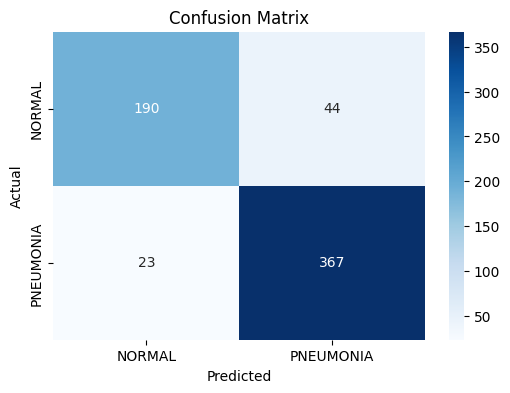

In [8]:
# ✅ Install TensorFlow (skip if already in Colab)
# !pip install tensorflow

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🔁 Set Paths to Dataset
train_dir = "/content/chest_xray/train"
val_dir = "/content/chest_xray/val"
test_dir = "/content/chest_xray/test"

# ✅ Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# 🔁 Generators
target_size = (224, 224)
batch_size = 32

train_gen = train_datagen.flow_from_directory(train_dir, target_size=target_size, batch_size=batch_size, class_mode='binary')
val_gen = val_test_datagen.flow_from_directory(val_dir, target_size=target_size, batch_size=batch_size, class_mode='binary')
test_gen = val_test_datagen.flow_from_directory(test_dir, target_size=target_size, batch_size=1, class_mode='binary', shuffle=False)

# ✅ Model: MobileNetV2
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
for layer in base_model.layers:
    layer.trainable = False  # Freeze base layers

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# ✅ Compute Class Weights
y_train = train_gen.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# ✅ Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1),
    ModelCheckpoint("xray_best_model.h5", save_best_only=True, monitor='val_loss')
]

# ✅ Train Model
model.fit(train_gen, validation_data=val_gen, epochs=10, class_weight=class_weights, callbacks=callbacks)

# ✅ Evaluate Model
y_true = test_gen.classes
y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype("int32")

# ✅ Classification Report
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [9]:
from google.colab import files
files.download('xray_best_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>